<a href="https://colab.research.google.com/github/senasnelson/Base_precatorio_cnj/blob/main/C%C3%B3pia_de_Resultados_Preliminares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização Financeira da Dívida de Precatórios: Modelo Preditivo com Machine Learning

#### Aluno(a): Nelson Gonçalves de Sena

#### Orientador(a): Edilson José Rodrigues

#### Curso: MBA em Data Science e Analytics


In [ ]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np

In [ ]:
# Configuração estética dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# 1. Base de Dados Histórica (Goiás)
caminho_arquivo = 'https://raw.githubusercontent.com/senasnelson/Base_precatorio_cnj/refs/heads/main/DatasetGO%202019-2025.csv'

df_hist = pd.read_csv(caminho_arquivo, sep=';', encoding='utf-8-sig')

# 2. Lista das colunas que são numéricas (RCL, Saldo, Montante, etc)
# Exceto 'UF' e 'Ano'
colunas_numericas = [
    'RCL', 'Perc_repasse', 'Saldo_dev_inicial', 'Montante_pago',
    'Saldo_apos_pgmto','Montante_expedido','Saldo_dev_final'
]

# 3. Função de limpeza para o padrão brasileiro
def limpar_numeros(valor):
    if isinstance(valor, str):
        valor = valor.replace('%', '')  # Remover símbolo %
        valor = valor.replace('.', '')  # Remover ponto milhar
        valor = valor.replace(',', '.') # Trocar vírgula decimal por ponto
        return float(valor)
    return valor

# 4. Transformar a coluna 'Perc_repasse' em valores decimais
df_hist['Perc_repasse'] = df_hist['Perc_repasse'].apply(limpar_numeros)

# 5. Aplicando a limpeza em todas as colunas numéricas
for col in colunas_numericas:
    df_hist[col] = df_hist[col].apply(limpar_numeros)

# 6. Representar os valores da coluna 'Perc_repasse' dividos por 100
df_hist['Perc_repasse'] = df_hist['Perc_repasse'] / 100

# 7. Exibir o resultado e os tipos de dados para conferir
print(df_hist.dtypes)
df_hist


UF                    object
Ano                    int64
RCL                  float64
Perc_repasse         float64
Saldo_dev_inicial    float64
Montante_pago        float64
Saldo_apos_pgmto     float64
Montante_expedido    float64
Saldo_dev_final      float64
dtype: object


,UF,Ano,RCL,Perc_repasse,Saldo_dev_inicial,Montante_pago,Saldo_apos_pgmto,Montante_expedido,Saldo_dev_final
0,GO,2019,2.453862e+10,0.0150,1.734171e+09,3.783966e+08,1.301269e+09,1.820141e+08,1.483283e+09
1,GO,2020,2.632334e+10,0.0150,1.469798e+09,4.148083e+08,1.048155e+09,2.859590e+08,1.334114e+09
2,GO,2021,3.154532e+10,0.0150,1.328574e+09,3.576045e+08,9.755589e+08,3.527819e+08,1.328341e+09
3,GO,2022,3.720835e+10,0.0150,1.322172e+09,6.507307e+08,8.823196e+08,1.867544e+08,1.069074e+09
4,GO,2023,3.840713e+10,0.0150,1.357931e+09,5.408919e+08,9.710361e+08,7.448739e+08,1.715910e+09
5,GO,2024,4.233006e+10,0.0150,1.716240e+09,5.316681e+08,1.272430e+09,7.992968e+08,2.071727e+09
6,GO,2025,4.537090e+10,0.0165,1.816850e+09,7.482779e+08,1.192156e+09,5.513709e+08,1.743527e+09


In [ ]:
# 2. Lista das colunas que são numéricas (RCL, Saldo, Montante, etc)
# Exceto 'UF' e 'Ano'
colunas_numericas = [
    'RCL', 'Perc_repasse', 'Saldo_dev_inicial', 'Montante_pago',
    'Saldo_apos_pgmto','Montante_expedido','Saldo_dev_final'
]

# 3. Função de limpeza para o padrão brasileiro
def limpar_numeros(valor):
    if isinstance(valor, str):
        valor = valor.replace('%', '')    # Remove o símbolo de porcentagem
        valor = valor.replace('.', '')    # Remove o ponto do milhar (ex: 1.000 -> 1000)
        valor = valor.replace(',', '.')   # Troca a vírgula decimal por ponto (ex: 0,50 -> 0.50)
        return float(valor)
    return valor

# 4. Transformar a coluna 'Perc_repasse' em valores decimais
df_hist['Perc_repasse'] = df_hist['Perc_repasse'].apply(limpar_numeros)

In [ ]:
# Bloco 2: Cálculo de Premissas (Time Series)
# Aqui calculamos a saúde financeira do estado e as taxas de crescimento.
# É o "coração" estatístico do TCC.
# Parâmetros Base (2025)
ultimo_ano = df_hist['Ano'].max()
saldo_base = df_hist.loc[df_hist['Ano'] == ultimo_ano, 'Saldo_dev_final'].values[0]
rcl_base = df_hist.loc[df_hist['Ano'] == ultimo_ano, 'RCL'].values[0]

# Cálculo da CAGR da RCL (Crescimento Histórico)
n_anos = ultimo_ano - df_hist['Ano'].min()
rcl_inicial = df_hist.loc[df_hist['Ano'] == df_hist['Ano'].min(), 'RCL'].values[0]
cagr_rcl = (rcl_base / rcl_inicial) ** (1/n_anos) - 1

# Média de novas dívidas que entram no sistema anualmente
fluxo_novas = df_hist['Montante_expedido'].mean()

# Premissa art. 3º EC. 136/2025:
# Saldo_dev_final atualizado a uma taxa_anual de ipca + juros 2% a.a.
# Projeções do ipca (30/01/2026): https://www.bcb.gov.br/publicacoes/focus
taxa_anual = {
    2026: 0.0399 + 0.020,
    2027: 0.0380 + 0.020,
    2028: 0.0350 + 0.020,
    2029: 0.0350 + 0.020,
    2030: 0.0350 + 0.020,
    2031: 0.0350 + 0.020,
    2032: 0.0350 + 0.020,
    2033: 0.0350 + 0.020,
    2034: 0.0350 + 0.020,
    2035: 0.0350 + 0.020
}

print(f"--- PREMISSAS DE MODELAGEM ---")
print(f"Saldo_dev_final (2025): R$ {saldo_base:,.2f}")
print(f"Crescimento Médio da RCL (CAGR): {cagr_rcl:.2%}")
print(f"Média de Novas Inscrições: R$ {fluxo_novas:,.2f}")

--- PREMISSAS DE MODELAGEM ---
Saldo_dev_final (2025): R$ 1,743,526,948.97
Crescimento Médio da RCL (CAGR): 10.79%
Média de Novas Inscrições: R$ 443,293,000.30


In [ ]:
#Bloco 3: Funções de Simulação e Otimização
#Defini a lógica que "prevê o futuro" e a função que busca o percentual ideal.
def simular(perc, anos=10):
    resultados = []
    saldo = saldo_base
    rcl = rcl_base


    for i in range(1, anos + 1):
        ano = ultimo_ano + i
        taxa = taxa_anual.get(ano_atual, 0.055)

        # 3.1 Evolução da Receita Corrente Líquida (RCL)
        rcl *= (1 + cagr_rcl)

        # 3.2 Atualização do Passivo = (Saldo_dev_final * (1 + taxa) + Mont. exp.
        # Busque a taxa anual correspondente para o ano atual,
        # usando 0.055 como valor padrão (default) caso não seja encontrada
        taxa = taxa_anual.get(ano, 0.055)
        saldo_corr = (saldo * (1 + taxa)) + fluxo_novas
        pagamento = rcl * perc
        amortizacao = min(pagamento, saldo_corr)
        saldo = max(0, saldo_corr - amortizacao)
        resultados.append({'Ano': ano, 'Saldo': saldo, 'Pagamento': amortizacao})
    return pd.DataFrame(resultados)

# Busca o percentual necessário para zerar em 2035
def buscar_ideal(ano_alvo=2035):
    for p in np.arange(0.005, 0.10, 0.0001):
        df_temp = simular(p)
        if df_temp.loc[df_temp['Ano'] == ano_alvo, 'Saldo'].values[0] <= 0:
            return p
    return None

perc_ideal = buscar_ideal()
print(f"Percentual necessário para quitação em 2035: {perc_ideal:.2%}")

NameError: name 'taxa_anual' is not defined

In [ ]:
#Bloco 4: Tabela Comparativa Final
#Este bloco gera a tabela que você quer para o seu relatório, comparando todos os cenários.
df_10 = simular(0.01)
df_15 = simular(0.015)
df_ideal = simular(perc_ideal)

tabela_final = pd.DataFrame({'Ano': [2024] + list(range(2025, 2031))})

def mapear_saldo(df_proj):
    saldos = [saldo_base]
    for ano in range(2025, 2031):
        val = df_proj.loc[df_proj['Ano'] == ano, 'Saldo'].values
        saldos.append(val[0] if len(val) > 0 else 0)
    return [round(s / 1e9, 3) for s in saldos]

tabela_final['Saldo 1.0% (R$ bi)'] = mapear_saldo(df_10)
tabela_final['Saldo 1.5% (R$ bi)'] = mapear_saldo(df_15)
tabela_final['Saldo Ideal (R$ bi)'] = mapear_saldo(df_ideal)

print("EVOLUÇÃO DO SALDO DEVEDOR POR CENÁRIO")
tabela_final


EVOLUÇÃO DO SALDO DEVEDOR POR CENÁRIO


,Ano,Saldo 1.0% (R$ bi),Saldo 1.5% (R$ bi),Saldo Ideal (R$ bi)
0,2024,2.072,2.072,2.072
1,2025,2.277,2.061,1.905
2,2026,2.437,1.969,1.631
3,2027,2.544,1.781,1.231
4,2028,2.587,1.482,0.686
5,2029,2.556,1.054,0.000
6,2030,2.435,0.476,0.000


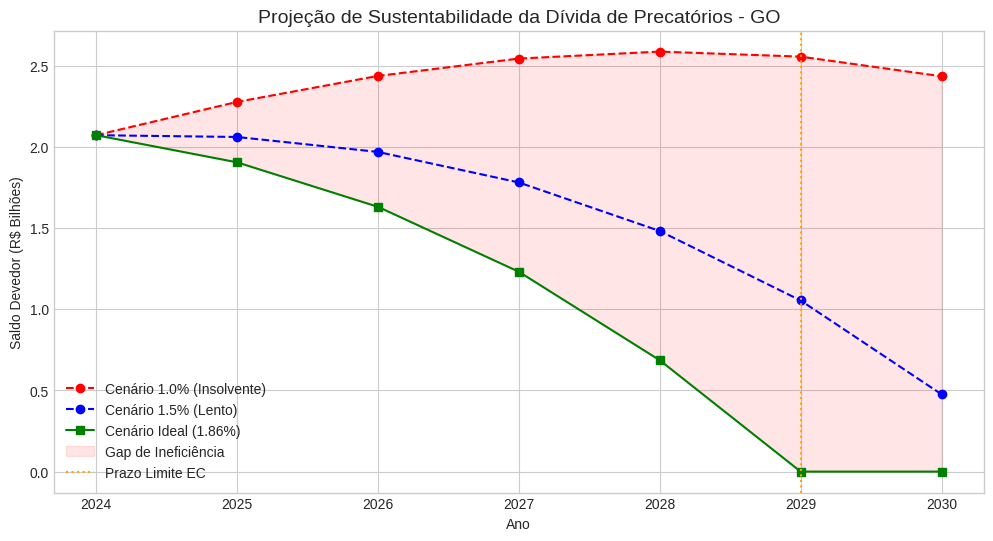

In [ ]:
#Bloco 5: Visualização Gráfica
#A última saída é o gráfico que ilustra o "Efeito Tesoura" da dívida.
plt.figure(figsize=(12, 6))
plt.plot(tabela_final['Ano'], tabela_final['Saldo 1.0% (R$ bi)'], 'r--o', label='Cenário 1.0% (Insolvente)')
plt.plot(tabela_final['Ano'], tabela_final['Saldo 1.5% (R$ bi)'], 'b--o', label='Cenário 1.5% (Lento)')
plt.plot(tabela_final['Ano'], tabela_final['Saldo Ideal (R$ bi)'], 'g-s', label=f'Cenário Ideal ({perc_ideal:.2%})')

plt.fill_between(tabela_final['Ano'], tabela_final['Saldo 1.0% (R$ bi)'], tabela_final['Saldo Ideal (R$ bi)'], color='red', alpha=0.1, label='Gap de Ineficiência')

plt.title("Projeção de Sustentabilidade da Dívida de Precatórios - GO", fontsize=14)
plt.ylabel("Saldo Devedor (R$ Bilhões)")
plt.xlabel("Ano")
plt.axvline(2029, color='orange', linestyle=':', label='Prazo Limite EC')
plt.legend()
plt.show()